# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
import random
warnings.filterwarnings("ignore")
warnings.simplefilter(action= 'ignore', category= FutureWarning)
pd.set_option('display.max_columns', 200)

# Declaring Functions

In [2]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
            
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

# Importing Data

In [3]:
path = 'C:/Users/TOTAGOUSER4/Documents/Totago Technologies/Data Science/Projects/Financial Inclusion in Africa/'

train = pd.read_csv(path + 'Train_v2.csv')
test = pd.read_csv(path + 'Test_v2.csv')

sub = pd.read_csv(path + 'SubmissionFile.csv')

In [4]:
##Checkpoint
data1 = train.copy()
data2 = test.copy()

In [5]:
##To display entire dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',  None)

In [6]:
##Mapping default status
train['bank_account'] = train['bank_account'].map({'No': 0, 'Yes': 1})

In [7]:
##Joining Train and Test
ntrain = train.shape[0]
ntest = test.shape[0]
dataset = pd.concat((train, test)).reset_index(drop=True)

In [8]:
##Checkpoint
data = dataset.copy()

# Feature Engineering

In [9]:
##Dropping Application ID
data.drop('uniqueid', axis =1, inplace = True)

In [10]:
##Creating Dummies and viewing data info
data = pd.get_dummies(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33610 entries, 0 to 33609
Data columns (total 41 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   year                                             33610 non-null  int64  
 1   bank_account                                     23524 non-null  float64
 2   household_size                                   33610 non-null  int64  
 3   age_of_respondent                                33610 non-null  int64  
 4   country_Kenya                                    33610 non-null  uint8  
 5   country_Rwanda                                   33610 non-null  uint8  
 6   country_Tanzania                                 33610 non-null  uint8  
 7   country_Uganda                                   33610 non-null  uint8  
 8   location_type_Rural                              33610 non-null  uint8  
 9   location_type_Urban         

In [11]:
##Getting train, target and test data
train = data[:ntrain].copy()
target = train.bank_account.copy()
train.drop('bank_account', axis=1, inplace=True)

test = data[ntrain:].copy()
test.drop('bank_account', axis=1, inplace=True)
test = test.reset_index(drop=True)

In [12]:
test.columns.sort_values()

Index(['age_of_respondent', 'cellphone_access_No', 'cellphone_access_Yes',
       'country_Kenya', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'education_level_No formal education',
       'education_level_Other/Dont know/RTA',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'gender_of_respondent_Female', 'gender_of_respondent_Male',
       'household_size', 'job_type_Dont Know/Refuse to answer',
       'job_type_Farming and Fishing', 'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed', 'location_type_Rural', 'location_type_Urban',
       'marital_status_Divorced/Seperated', 'marital_status_Dont k

# Data Modelling

================================Fold1====================================
0:	test: 0.6535040	best: 0.6535040 (0)	total: 311ms	remaining: 51m 51s
50:	test: 0.8178985	best: 0.8178985 (50)	total: 4.47s	remaining: 14m 32s
100:	test: 0.8162934	best: 0.8184853 (86)	total: 8.85s	remaining: 14m 27s
150:	test: 0.8184198	best: 0.8187487 (148)	total: 13.3s	remaining: 14m 28s
200:	test: 0.8204290	best: 0.8206235 (178)	total: 17.5s	remaining: 14m 14s
250:	test: 0.8214228	best: 0.8214228 (250)	total: 21.7s	remaining: 14m 4s
300:	test: 0.8224004	best: 0.8224004 (300)	total: 25.7s	remaining: 13m 49s
350:	test: 0.8231290	best: 0.8231600 (341)	total: 29.7s	remaining: 13m 36s
400:	test: 0.8236289	best: 0.8236852 (387)	total: 33.9s	remaining: 13m 31s
450:	test: 0.8236169	best: 0.8236852 (387)	total: 38.4s	remaining: 13m 32s
500:	test: 0.8238412	best: 0.8238442 (499)	total: 43s	remaining: 13m 34s
550:	test: 0.8240640	best: 0.8240946 (531)	total: 47s	remaining: 13m 26s
600:	test: 0.8242875	best: 0.8242875 (

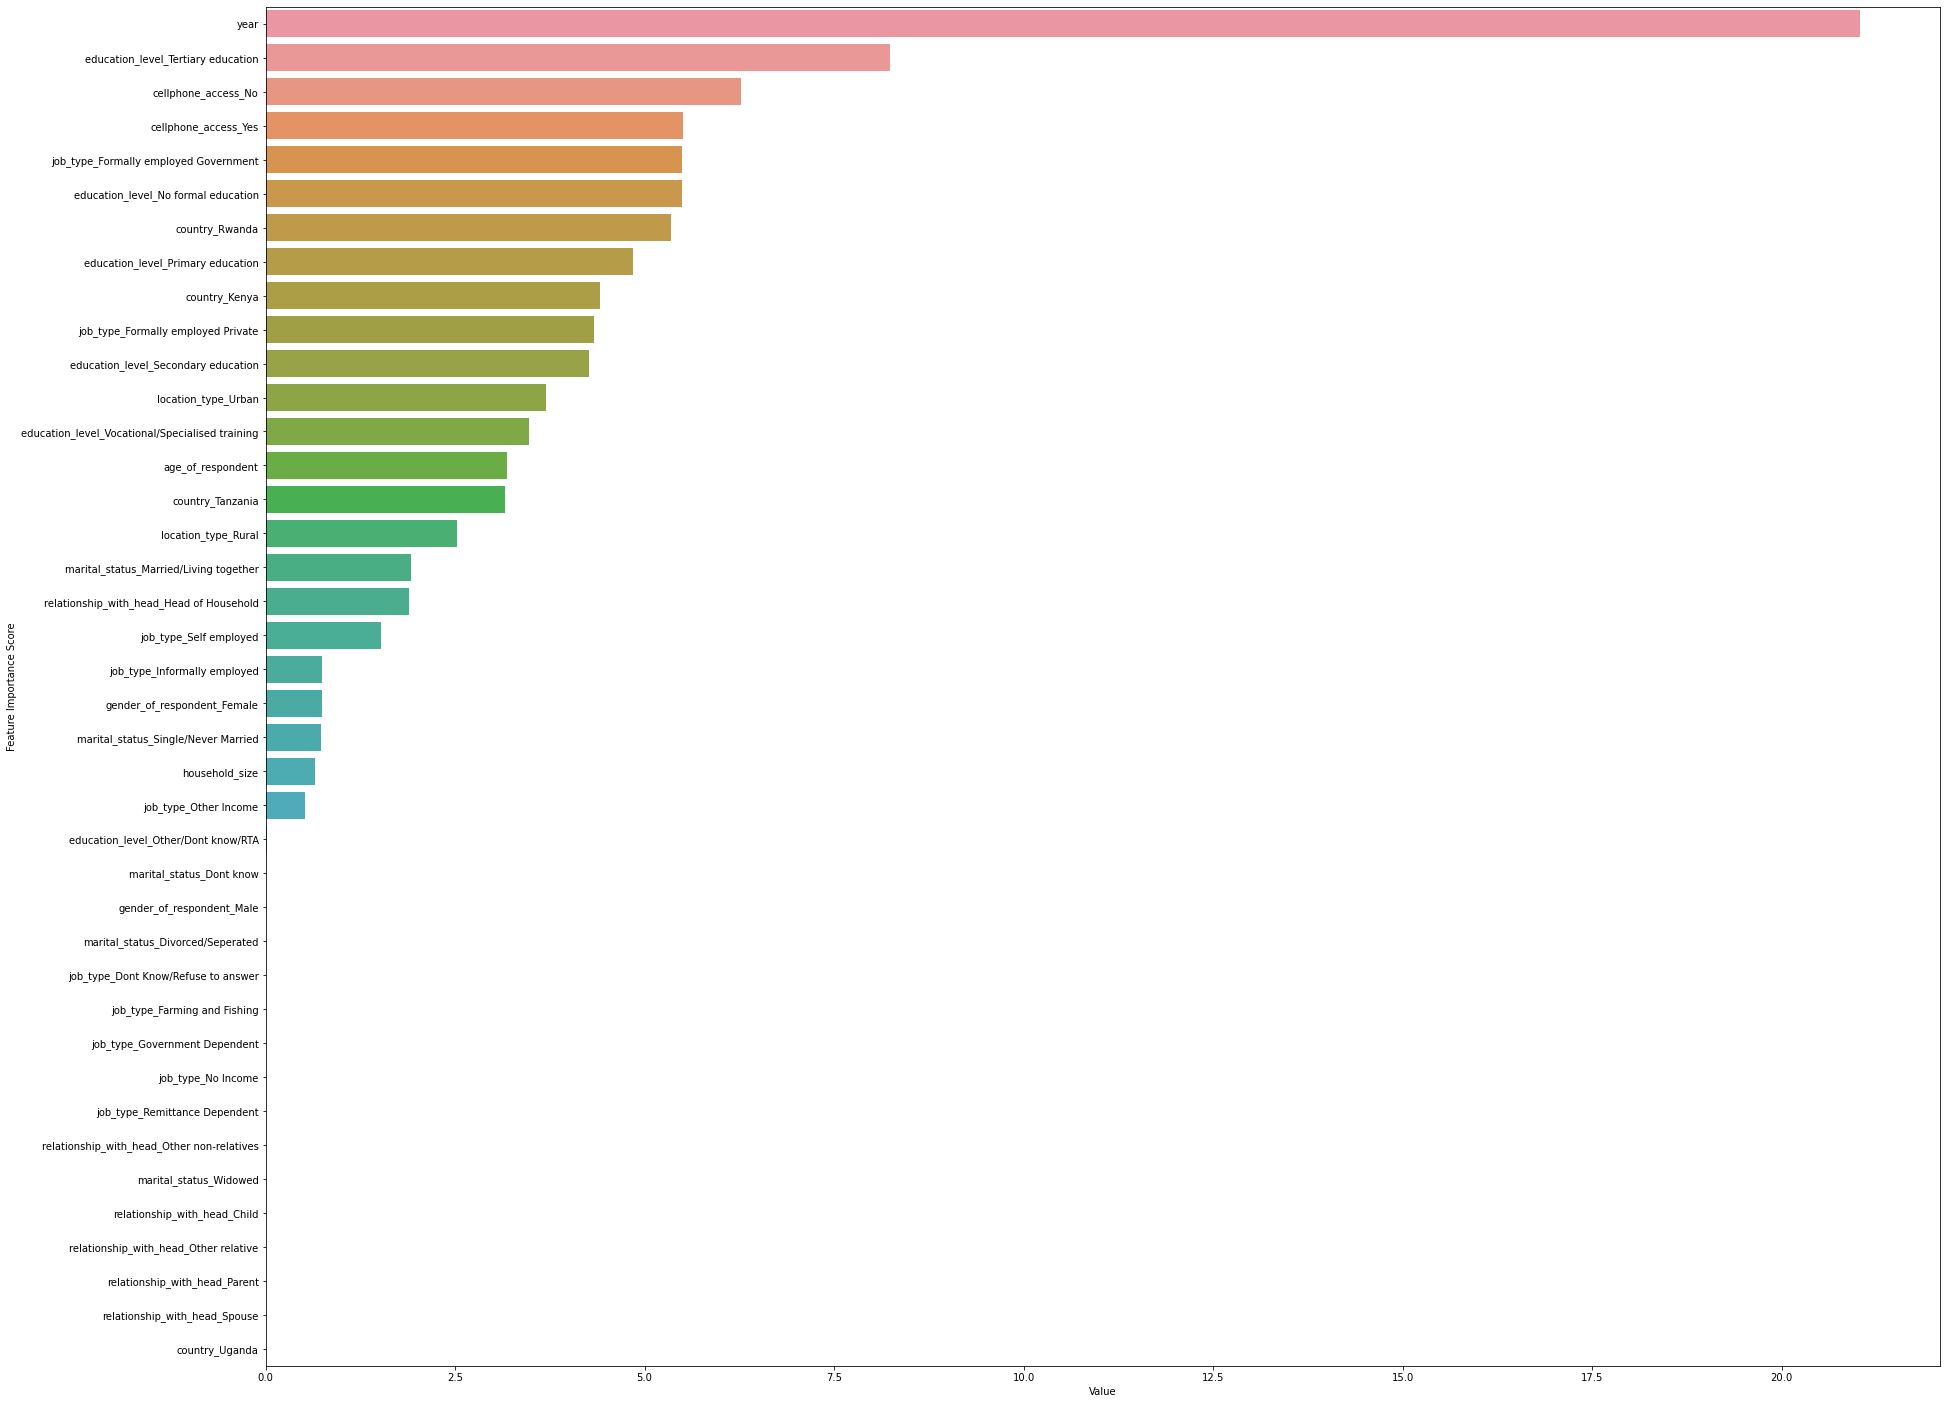

0.7989793743764896 0.8557101608776254 0.038143734460839455


In [13]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370)#, task_type="GPU", devices='0:1')

func_= func(train, target, test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

================================Fold1====================================
[12:26:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.63962
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.71862
[2]	validation_0-auc:0.73644
[3]	validation_0-auc:0.76282
[4]	validation_0-auc:0.78596
[5]	validation_0-auc:0.79241
[6]	validation_0-auc:0.79234
[7]	validation_0-auc:0.79935
[8]	validation_0-auc:0.80136
[9]	validation_0-auc:0.80155
[10]	validation_0-auc:0.80037
[11]	validation_0-auc:0.80231
[12]	validation_0-auc:0.80303
[13]	validation_0-auc:0.80505
[14]	validation_0-auc:0.80522
[15]	validation_0-auc:0.80565
[16]

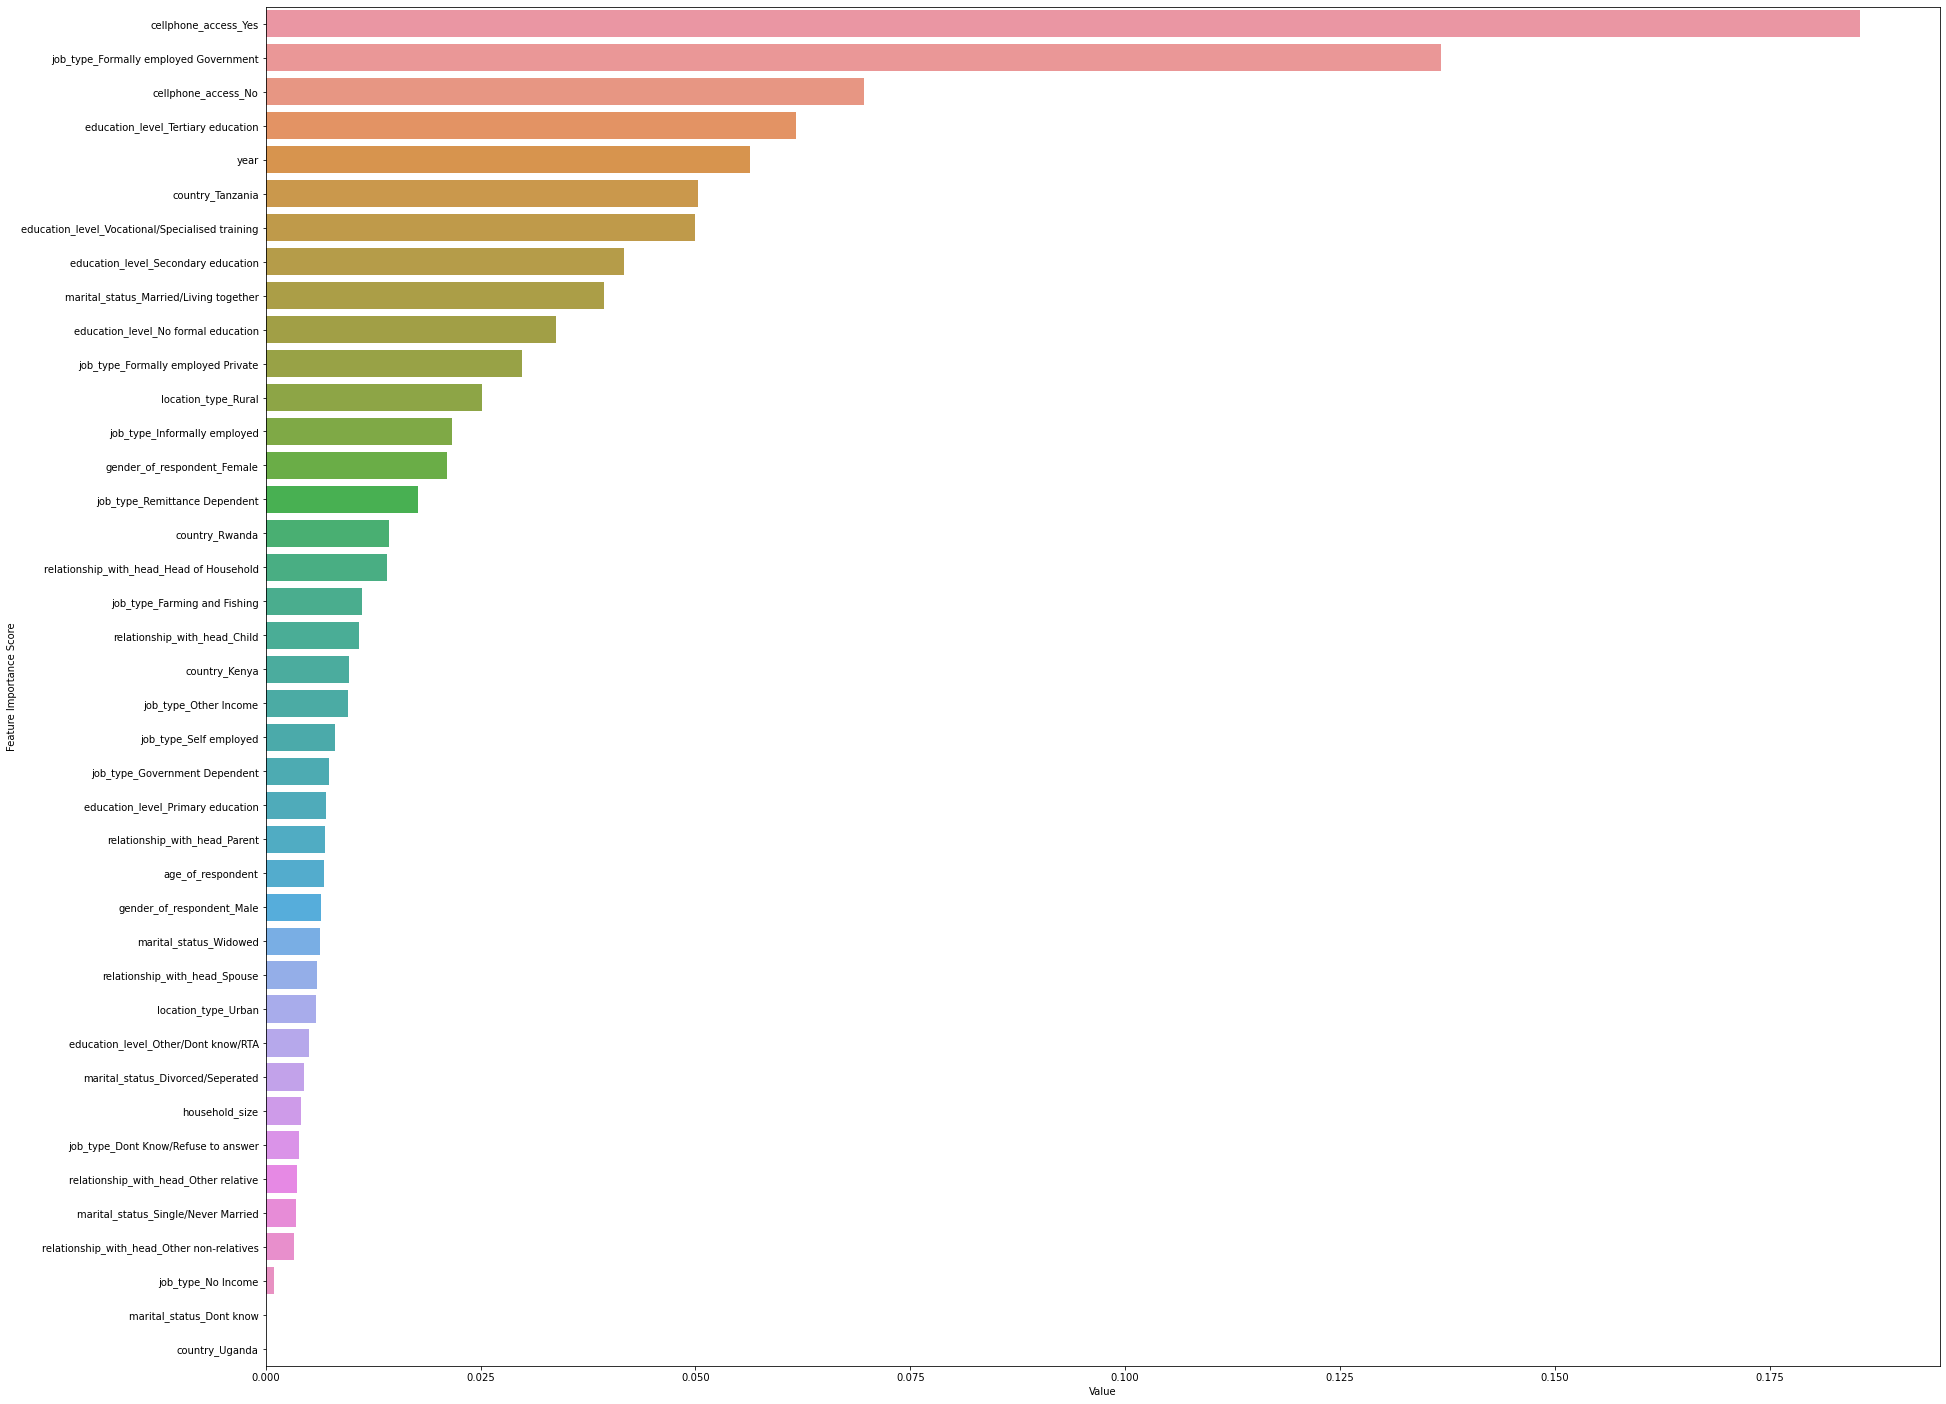

0.7984875075511929 0.8901438273946312 0.03477976427479649


In [14]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8) #, tree_method='gpu_hist') #, gpu_id=0)

func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

================================Fold1====================================
[1]	valid_0's auc: 0.637419
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.693459
[3]	valid_0's auc: 0.724942
[4]	valid_0's auc: 0.75718
[5]	valid_0's auc: 0.758167
[6]	valid_0's auc: 0.767989
[7]	valid_0's auc: 0.765258
[8]	valid_0's auc: 0.777864
[9]	valid_0's auc: 0.783602
[10]	valid_0's auc: 0.780595
[11]	valid_0's auc: 0.781463
[12]	valid_0's auc: 0.777695
[13]	valid_0's auc: 0.785203
[14]	valid_0's auc: 0.786726
[15]	valid_0's auc: 0.783919
[16]	valid_0's auc: 0.789174
[17]	valid_0's auc: 0.794107
[18]	valid_0's auc: 0.796835
[19]	valid_0's auc: 0.797568
[20]	valid_0's auc: 0.800126
[21]	valid_0's auc: 0.800016
[22]	valid_0's auc: 0.803831
[23]	valid_0's auc: 0.803541
[24]	valid_0's auc: 0.803068
[25]	valid_0's auc: 0.80306
[26]	valid_0's auc: 0.804399
[27]	valid_0's auc: 0.805648
[28]	valid_0's auc: 0.805319
[29]	valid_0's auc: 0.805859
[30]	valid_0's auc: 0.806493
[31]	v

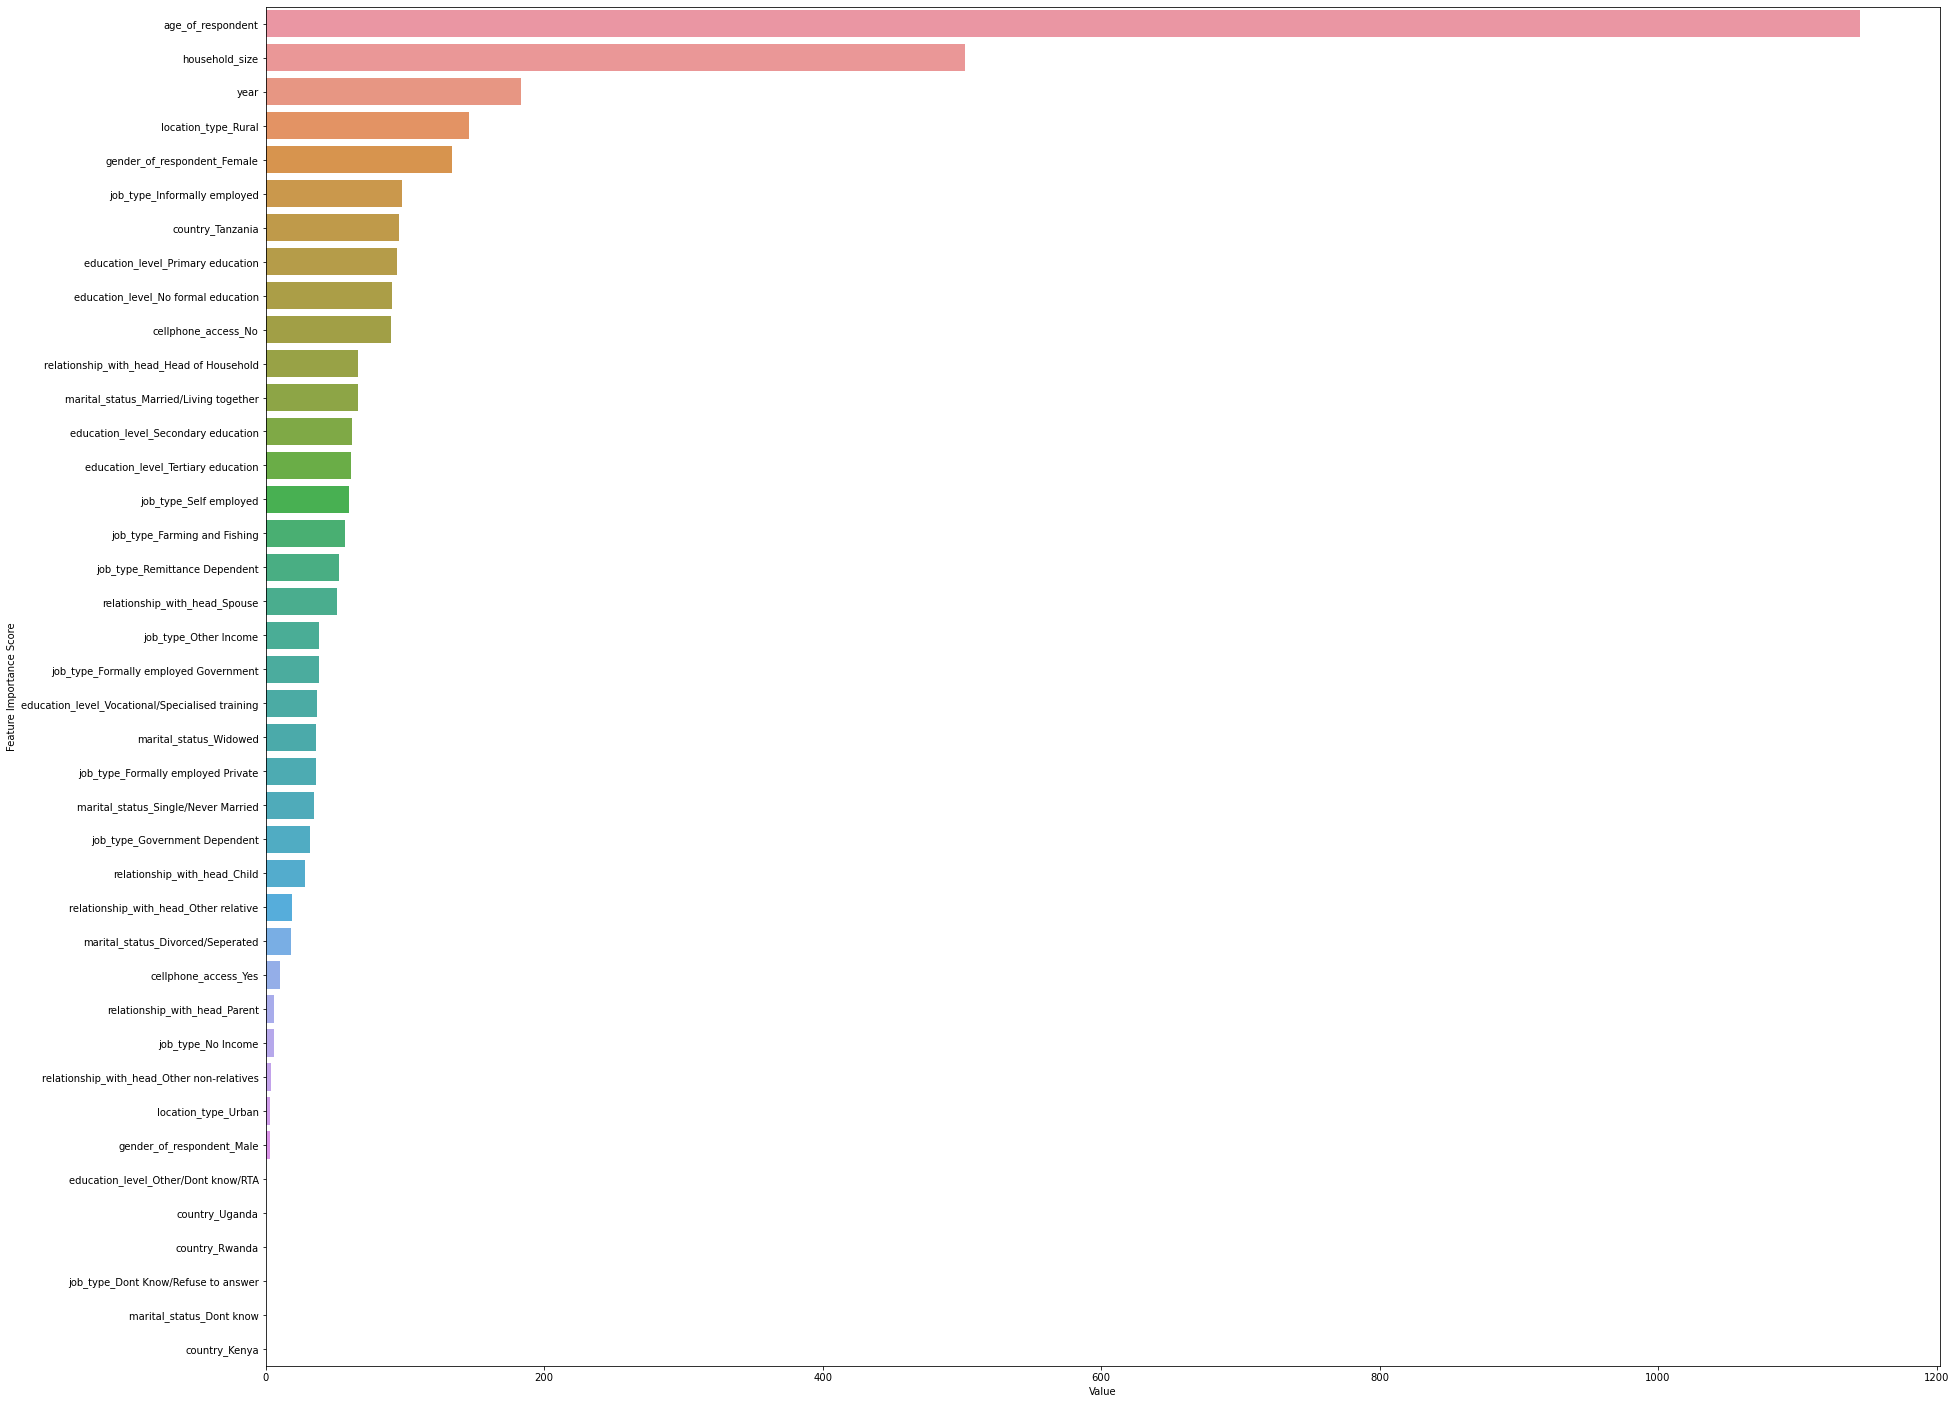

0.7993379635695661 0.8929721763720672 0.03284962159651441


In [15]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

In [16]:
test1_cat1 = test_p1
test1_xg1 = test_p2
test1_lgbm1 = test_p3

val1_cat1 = val_p1
val1_xg1 = val_p2
val1_lgbm1 = val_p3

model1_cat1 = model1
model1_xg1 = model2
model1_lgbm1 = model3


# Stacking

In [17]:
# stacking based on line of best fit between the three models

from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)

In [18]:
sub['default_status'] = predict

In [19]:
##Saving the prediction

sub.to_csv(path + 'my_prediction2.csv', index = False)